In [1]:
import pandas as pd
import numpy as np


In [2]:
data = pd.read_csv("/content/drive/MyDrive/IMDB movie review/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [4]:
data.dtypes

review       object
sentiment    object
dtype: object

In [5]:
import nltk
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()


In [7]:
data['review'] = data['review'].str.lower()

In [8]:
#data['review'].replace("[^a-zA-Z]"," ",regex=True,inplace=True)

In [9]:
data['review'].replace('https?://\S+|www\.\S+'," ",regex=True,inplace=True)
data['review'].replace('<.*?>'," ",regex=True,inplace=True)
data['review'].replace('@\w+'," ",regex=True,inplace=True)
data['review'].replace('#\w+'," ",regex=True,inplace=True)
data['review'].replace("[^\w\s\d]"," ",regex=True,inplace=True)
data['review'].replace(r'( +)'," ",regex=True,inplace=True)
data['review'].replace("[^a-zA-Z]"," ",regex=True,inplace=True)

In [10]:
#train = data['review'][:40000]
#test = data['review'][40000:]

In [11]:
#len(test)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,LSTM
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
data_lem = []
for i in range(0,len(data.index)):
  temp = data['review'][i].split()
  temp = [word.lower() for word in temp]
  temp = [word for word in temp if word not in stopwords.words("english")]
  temp = " ".join(temp)
  data_lem.append(temp)

In [14]:
voc_size = 90000

In [15]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer(num_words=voc_size,oov_token='<OOV>')
t.fit_on_texts(data_lem)
word_index=t.word_index
total_vocab=len(word_index)

In [16]:
#onehot_rep = [one_hot(word,voc_size) for word in data_lem]
#len(onehot_rep[0])
total_vocab

99126

In [17]:
train = t.texts_to_sequences(data_lem)

In [18]:
set_length = 700
embedded_docs_train = pad_sequences(train,padding='pre',maxlen =set_length)

In [19]:
from tensorflow.keras.layers import Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Bidirectional

In [21]:
import keras
opt = keras.optimizers.Adam(learning_rate=0.01)

In [31]:
import keras
vector_feature = 200
model = Sequential()
model.add(Embedding(voc_size,vector_feature,input_length=set_length))
Dropout(0.20)
#model.add(Dense(128, activation='relu'))
model.add(LSTM(64,return_sequences=True))
#Dropout(0.25)
#model.add(LSTM(32,return_sequences=True))
#Dropout(0.25)
#model.add(BatchNormalization())
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
#Dropout(0.25)
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['categorical_accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 700, 200)          18000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 700, 64)           67840     
_________________________________________________________________
flatten_1 (Flatten)          (None, 44800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 44801     
Total params: 18,112,641
Trainable params: 18,112,641
Non-trainable params: 0
_________________________________________________________________


In [33]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
#data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
labels = pd.get_dummies(data['sentiment'],drop_first=True)


In [34]:
labels['positive'] = labels['positive'].astype(int)

In [35]:
x_final = embedded_docs_train
y_final = labels['positive']

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.33)

In [37]:
y_test.shape

(16500,)

In [38]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=4,batch_size=64,verbose=1)

Epoch 1/4
524/524 [==============================] - 701s 1s/step - loss: 0.3206 - accuracy: 0.8559 - val_loss: 0.2552 - val_accuracy: 0.8998
Epoch 2/4
524/524 [==============================] - 693s 1s/step - loss: 0.1100 - accuracy: 0.9596 - val_loss: 0.3136 - val_accuracy: 0.8897
Epoch 3/4
524/524 [==============================] - 696s 1s/step - loss: 0.0263 - accuracy: 0.9913 - val_loss: 0.5095 - val_accuracy: 0.8848
Epoch 4/4
524/524 [==============================] - 697s 1s/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 0.6708 - val_accuracy: 0.8809


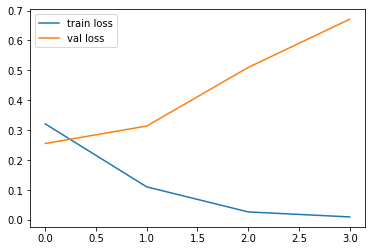

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.show()

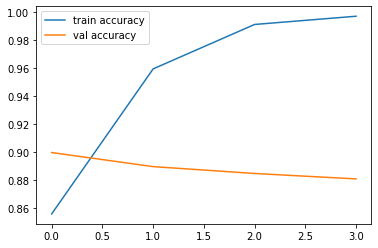

In [40]:

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.show()

In [48]:
predict = model.predict(X_test)
len(predict)

16500

In [54]:
predict[0]

array([0.7437487], dtype=float32)

In [55]:
sent = []
for i in range(len(predict)):
    if predict[i] >= 0.5:
      sent.append(1)
    else:
      sent.append(0)


In [57]:
len(sent)

16500

In [64]:
y_test

19423    1
43483    1
21318    0
46916    1
30764    0
        ..
23547    1
6901     0
28809    0
33737    1
48477    0
Name: positive, Length: 16500, dtype: int64

In [71]:
result = pd.DataFrame(list(zip(sent,np.array(y_test))),columns=['predict','actual'])

In [72]:
result

,predict,actual
0,1,1
1,1,1
2,0,0
3,1,1
4,0,0
...,...,...
16495,1,1
16496,0,0
16497,1,0
16498,1,1


In [74]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.array(y_test),sent)

array([[7078, 1097],
       [ 868, 7457]])

In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(np.array(y_test),sent)

0.8809090909090909